# Final Project: Predicting Subscribing Behavouirs using Hours Played and Age

## Introduction 

The Pacific Laboratory for Artificial Intelligence(PLAI), led by Frank Wood, is exploring individual behaviour in video games. Their research will enable them to create more sophisticated AI capable of acting in an intricate virtual environment. Particularly, they set up a Minecraft server(PLAICRAFT) to observe player interactions with other players, both voice and behavioural, along with hours spent playing. For players under the age of 13, a parental consent form was filled out.  


PLAI’s board question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?. 

This board question allowed us to formulate our **specific question** that is: Can hours played and Age predict whether the player is subscribing to the game-related newsletter?


### Data Description:

| Variable       | Type        | Description                                                  |
|----------------|------------|--------------------------------------------------------------|
| experience     | categorical | Self-reported gaming experience (Beginner to  Veteran). |
| subscribe      | logical     | Whether the player subscribed to the game newsletter(TRUE or FALSE).       |
| hashedEmail    | character   | Anonymized player identifier (used to join with sessions).  |
| played_hours   | numeric     | Self-reported hours previously spent playing Minecraft.     |
| name           | character   | Player’s name or nickname (identifier, not a predictor).    |
| gender         | categorical | Self-reported gender.                                       |
| Age            | numeric     | Self-reported age in years.                                 |


## Methods

### Exploratory Data Analysis and Visualization 

1. Load all the necessary libraries for data analysis along with `players.csv` from Canvas.
2. The dataset is already Tidy, so we will clean the dataset just to include predictors and response variables. Change the `subscribe` column to data type `fct` for knn-classification
3. Compute the summary statistics for the whole dataset.
4. Visualize the relationship between `Age`(years) and `played_hours`(hrs) with label `subscribe`

In [4]:
library(tidyverse)
library(tidymodels)
library(repr)
library(ggplot2)
options(repr.plot.width = 12, repr.plot.height = 6) #formats all scatterplots 

In [5]:
players_url <- "https://raw.githubusercontent.com/604Beast/FINAL_Project_GROUP27/refs/heads/main/players.csv"
players <- read_csv(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
players_clean <- players |>
                select(subscribe,played_hours, Age) |> 
                mutate(subscribe = as.factor(subscribe)) 
head(players_clean)
                

subscribe played_hours Age
1 TRUE      30.3          9 
2 TRUE       3.8         17 
3 FALSE      0.0         17 
4 TRUE       0.7         21 
5 TRUE       0.1         21 
6 TRUE       0.0         17

Figure  1


In [7]:
num_obs <-nrow(players_clean)
players_summary <- players_clean|> 
            group_by(subscribe) |>
            summarize(mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2 ), #rounded to 2 decimals
                     mean_Age = round(mean(Age, na.rm = TRUE), 2), 
                     count = n(),
            percentage = round(n() / num_obs * 100, 2))

players_summary 

subscribe mean_played_hours mean_Age count percentage
1 FALSE     0.50              23.75     52   26.53     
2 TRUE      7.78              20.18    144   73.47

Figure 2

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


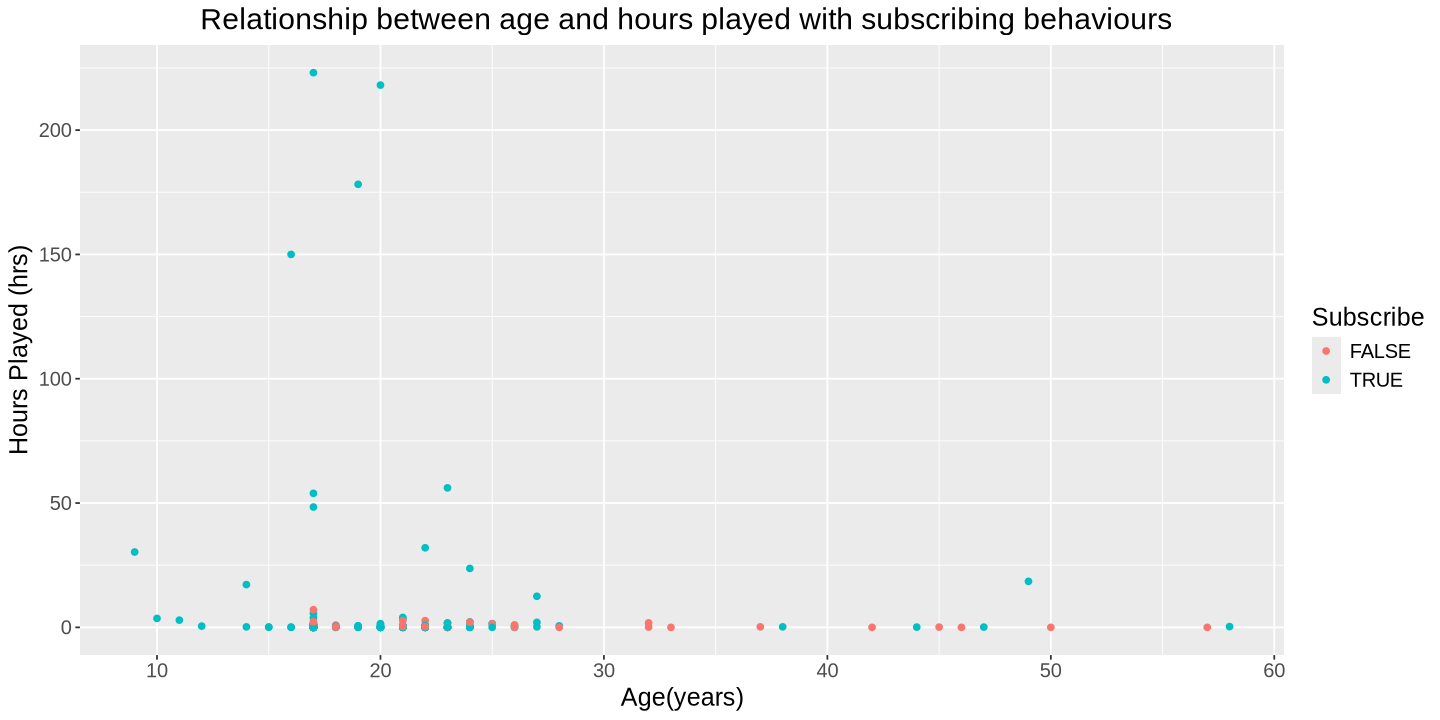

In [8]:

players_plot <- ggplot(players_clean, aes( x = Age, y = played_hours, color = subscribe))+
                    geom_point()+
                    ggtitle(" Relationship between age and hours played with subscribing behaviours") + 
                    labs( x = "Age(years)", y = "Hours Played (hrs)", color = "Subscribe")+ 
                    theme(text = element_text(size = 15)) +
                    theme(plot.title = element_text(hjust =0.5))
players_plot

Figure 3

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


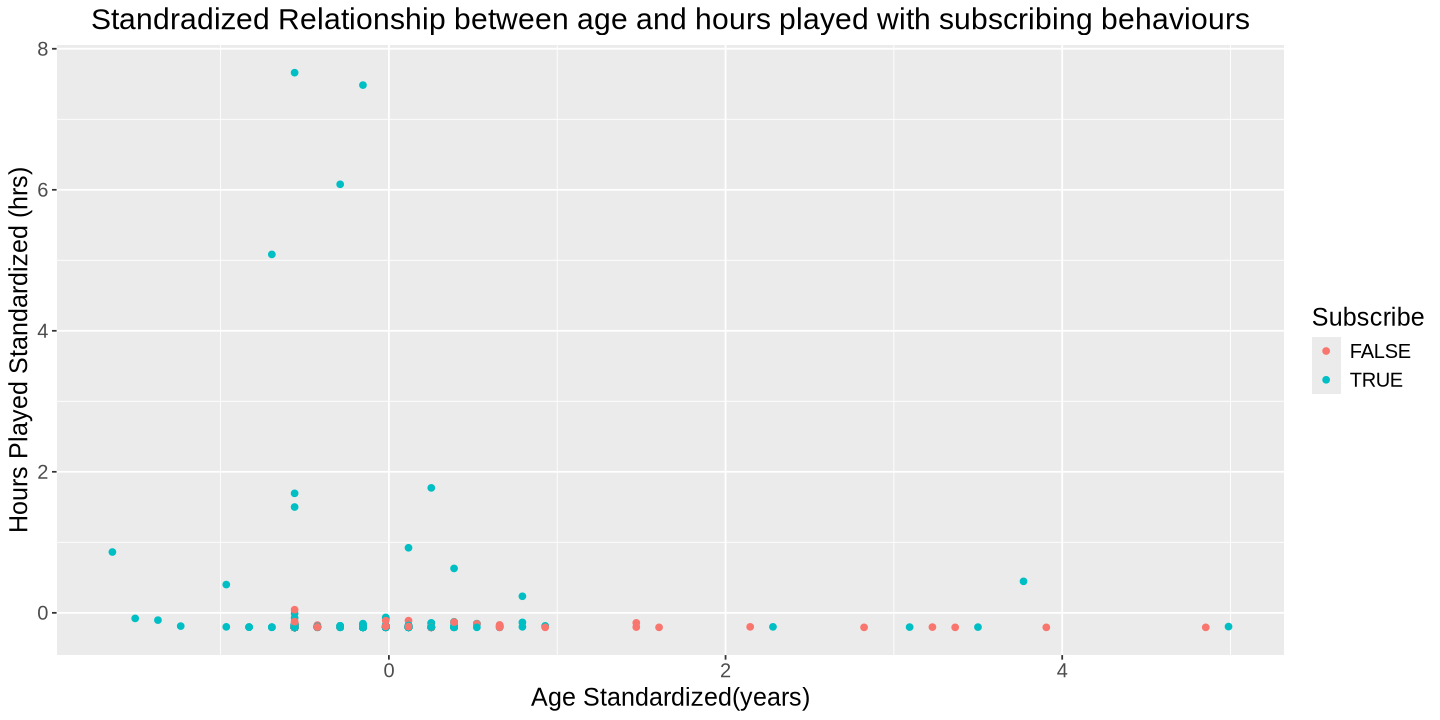

In [9]:
players_standardized <- subscribe_recipe <- recipe(subscribe ~ played_hours + Age, data = players_clean) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    prep() |>
                    bake(players_clean)

players_plot <-ggplot(players_standardized, aes( x = Age, y = played_hours, 
                                            color = subscribe))+
                    geom_point()+
                    ggtitle("Standradized Relationship between age and hours played with subscribing behaviours") + 
                    labs( x = "Age Standardized(years)", y = "Hours Played Standardized (hrs)", color = "Subscribe")+ 
                    theme(text = element_text(size = 15)) +
                    theme(plot.title = element_text(hjust =0.5))
players_plot

### Classifier preprocessing and finding the best $k$ value
1. Split the dataset into training and testing sets; the classifier will use the training set.
2. Summarize the training set

In [10]:
players_split <- initial_split(players_clean, prop = 0.70, strata = subscribe)  
players_training <- training(players_split)
players_testing <-testing(players_split)

head(players_training)
nrow(players_training)  
nrow(players_testing) 

subscribe played_hours Age
1 FALSE     0.0          21 
2 FALSE     0.1          17 
3 FALSE     0.0          23 
4 FALSE     0.0          33 
5 FALSE     1.4          25 
6 FALSE     0.0          24

[1] 136

[1] 60

In [12]:
set.seed(9999)
players_recipe <- recipe(subscribe ~ played_hours +Age, data = players_training)|> 
                step_scale(all_predictors()) |>
                step_center(all_predictors())

In [28]:
players_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
            set_engine("kknn")|>
            set_mode("classification") 

In [29]:
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = c(1:50))

In [30]:
players_results <-workflow() |>
                add_recipe(players_recipe)|>
                add_model(players_tune) |>
                tune_grid(resamples = players_vfold, grid = k_vals)|>
                collect_metrics()|>
                filter(.metric == "accuracy")|>
                select(neighbors, mean) |>
                arrange(desc(mean))

head(players_results)

neighbors mean     
1 22        0.7428571
2 23        0.7428571
3 24        0.7428571
4 21        0.7357143
5 18        0.7354497
6 25        0.7354497

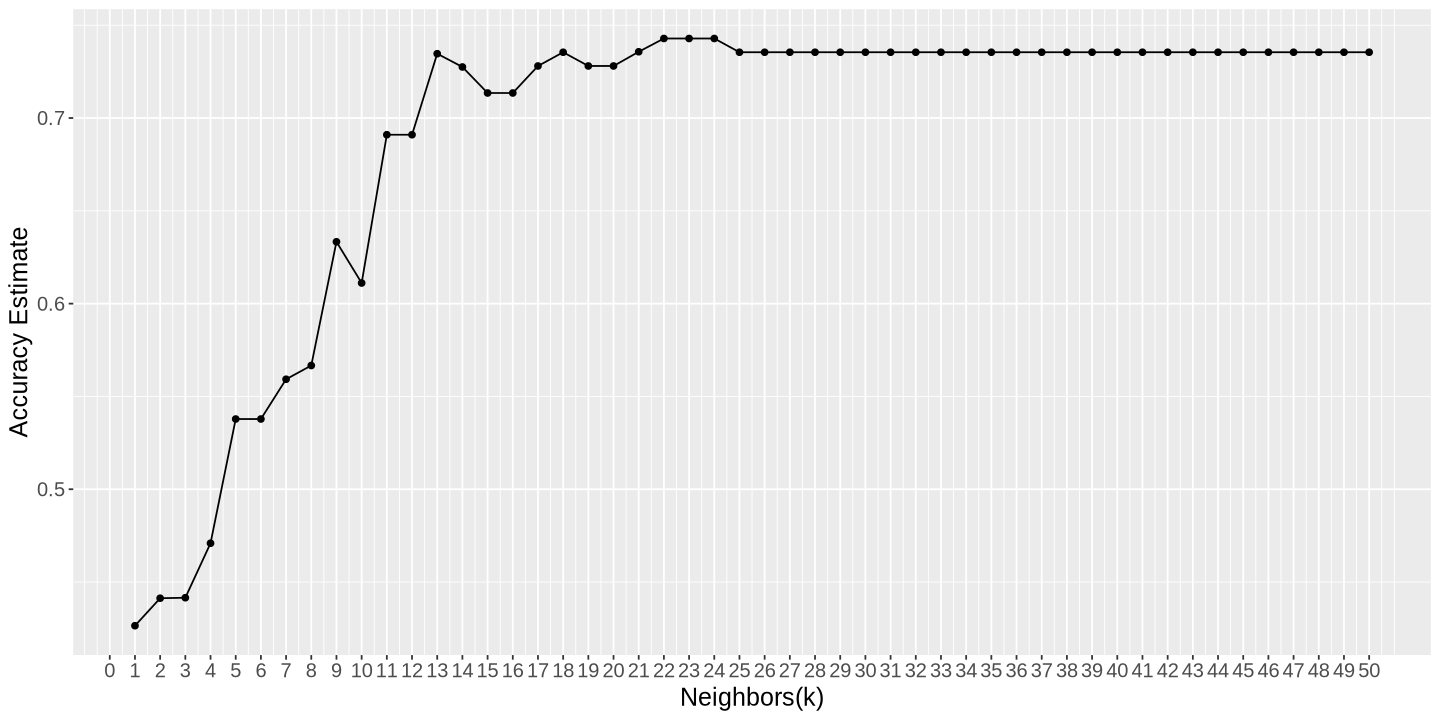

In [31]:
accuracy_vs_k <- ggplot(players_results, aes(x = neighbors, y = mean))+ 
                geom_point()+ 
                geom_line()+ 
                labs( x = "Neighbors(k)", y = "Accuracy Estimate") + 
                scale_x_continuous(breaks = seq(0,50, by = 1)) + 
                theme(text = element_text(size = 15))
accuracy_vs_k

In [13]:
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) |>
                set_engine("kknn") |>
                set_mode("classification")

players_fit <- workflow() |>
            add_recipe(players_recipe) |>
            add_model(players_best_spec) |>
            fit(data = players_training)
players_fit
                                       

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(23,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2462687
Best kernel: rectangular
Best k: 23

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


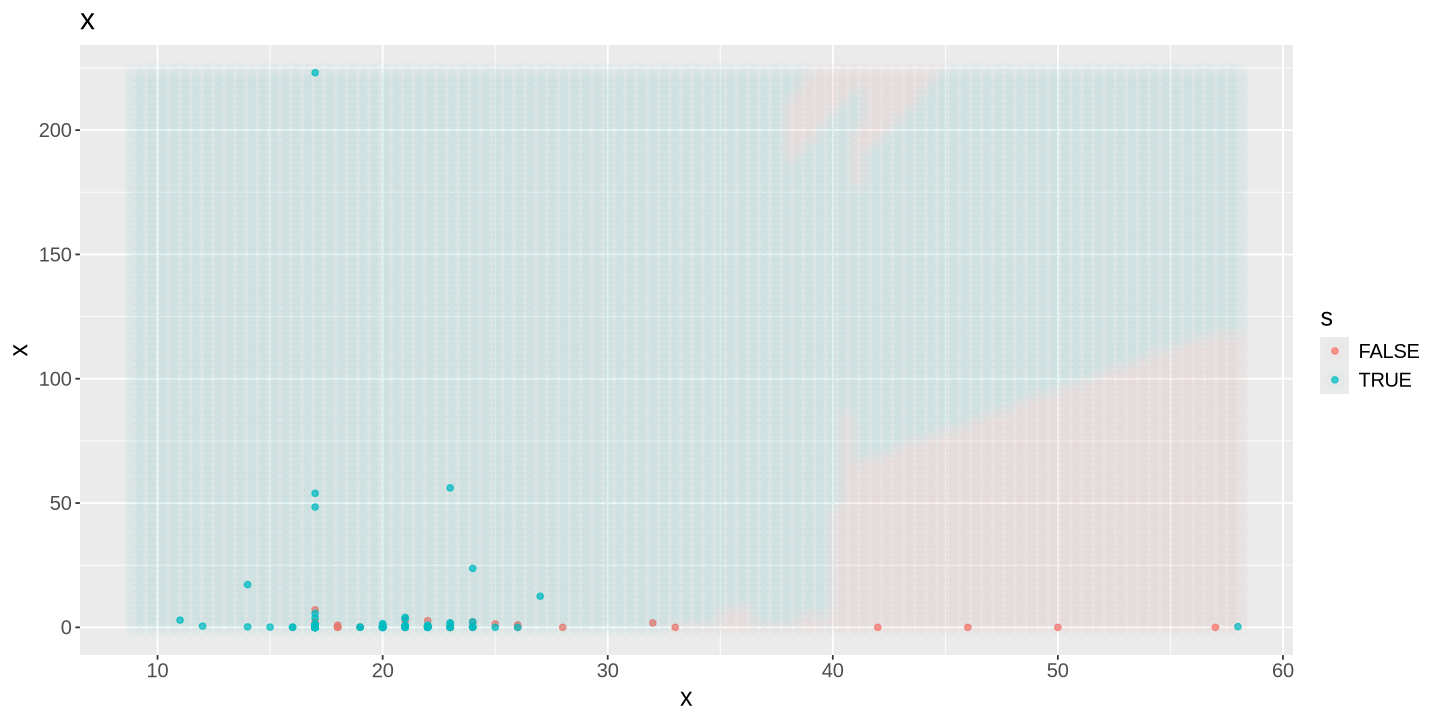

In [33]:
played_hours_grid<- seq(min(players_clean$played_hours), 
                max(players_clean$played_hours ), 
                length.out = 100)

Age_grid <- seq(min(players_clean$Age,na.rm = TRUE), 
                max(players_clean$Age, na.rm= TRUE), 
                length.out = 100)

all_grid <- as_tibble(expand.grid(played_hours =  played_hours_grid, 
                        Age= Age_grid))

predgrid <- predict(players_fit, all_grid)
pred_table <- bind_cols(predgrid,all_grid) 


plot_results <- ggplot(players_training, aes(x = Age, y = played_hours, color = subscribe)) + 
                geom_point(alpha = 0.75) +
                geom_point(data = pred_table, aes(color=.pred_class),
                           alpha = 0.02, 
                           size = 5) +
                labs(x = "x", y = "x", 
                     color = "s", 
                     title = "x") +
                theme(text = element_text(size = 15))

plot_results

In [15]:
players_predictions <- predict(players_fit, players_testing) |>
                bind_cols(players_testing) 

In [16]:
players_metrics <- players_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)|>
        filter( .metric == "accuracy")

players_metrics

.metric  .estimator .estimate
1 accuracy binary     0.7

In [17]:
players_conf_mat <- players_predictions |>
                    conf_mat(truth = subscribe, estimate = .pred_class)

players_conf_mat
                

          Truth
Prediction FALSE TRUE
     FALSE     2    4
     TRUE     14   40